In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('/content/LG.csv')
df_reversed = df.loc[::-1].reset_index(drop=True)
df1=df.reset_index()['Close']
features = df_reversed[['Open', 'High', 'Low', 'Close']].values

In [3]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# Xây dựng mô hình RNN
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))


In [9]:
# Biên dịch mô hình
rnn_model.compile(optimizer='adam', loss='mse')

In [10]:
# Huấn luyện mô hình RNN
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
32/32 [==============================] - 5s 25ms/step - loss: 0.0397 - val_loss: 0.0026
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 4.3572e-04
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 8.8007e-04
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 8.2541e-04
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 9.4642e-04 - val_loss: 4.3818e-04
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 9.1021e-04 - val_loss: 3.8286e-04
Epoch 8/50
32/32 [==============================] - 0s 7ms/step - loss: 9.0159e-04 - val_loss: 6.0522e-04
Epoch 9/50
32/32 [==============================] - 0s 8ms/step - loss: 8.5713e-04 - val_loss: 3.0438e-04
Epoch 10/50
32/32 [==============================] - 0s 7ms/step - loss: 

In [11]:
# Trích xuất các đặc trưng từ tầng cuối cùng của RNN
train_features_rnn = rnn_model.predict(X_train)
test_features_rnn = rnn_model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


In [12]:
# Kết hợp các đặc trưng từ RNN với các đặc trưng khác (ở đây chỉ dùng các đặc trưng từ RNN)
X_train_combined = train_features_rnn
X_test_combined = test_features_rnn


In [13]:
X_train_combined.shape
X_test_combined.shape

(475, 1)

In [14]:
# Tạo dataset cho LightGBM
train_data = lgb.Dataset(X_train_combined, label=y_train)
test_data = lgb.Dataset(X_test_combined, label=ytest, reference=train_data)


In [15]:
# Thiết lập các tham số cho LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [16]:
# Huấn luyện mô hình LightGBM với early stopping
evals_result = {}
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.record_evaluation(evals_result)]
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
# Dự đoán và đánh giá
y_pred = lgb_model.predict(X_test_combined, num_iteration=lgb_model.best_iteration)
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm tính RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(ytest, y_pred)
rmse = root_mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

# In ra các chỉ số đánh giá
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1243, number of used features: 1
[LightGBM] [Info] Start training from score 0.424319
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	train's rmse: 0.0201853	valid's rmse: 0.0153077
Mean Squared Error (MSE): 0.0002343246939910895
Root Mean Squared Error (RMSE): 0.015307667816852099
Mean Absolute Error (MAE): 0.010728413058809146
Mean Absolute Percentage Error (MAPE): 2.379447778039744%


In [17]:
# 10. Hàm dự đoán 30 ngày tiếp theo
def predict_next_30_days(rnn_model, lgb_model, initial_data, time_step=100):
    predictions = []
    current_sequence = initial_data  # Lấy chuỗi dữ liệu cuối cùng làm dữ liệu khởi đầu

    for _ in range(30):
        # Reshape data for prediction
        current_sequence_reshaped = np.expand_dims(current_sequence, axis=0)

        # Predict features using RNN
        rnn_features = rnn_model.predict(current_sequence_reshaped)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features, num_iteration=lgb_model.best_iteration)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the sequence with the new prediction
        next_day = np.array([[next_close[0]]])
        current_sequence = np.vstack((current_sequence, next_day))

    return predictions

# Chuẩn bị dữ liệu ban đầu cho dự đoán 30 ngày tiếp theo
initial_data = df1.reshape(-1, 1)

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_next_30_days(rnn_model, lgb_model, initial_data)
print("Dự đoán giá đóng cửa cho 30 ngày tiếp theo:", next_30_days_predictions)

1/1 [==============================] - 0s 34ms/step
Dự đoán giá đóng cửa cho 30 ngày tiếp theo: [0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045]


In [18]:
print(len(next_30_days_predictions))

30


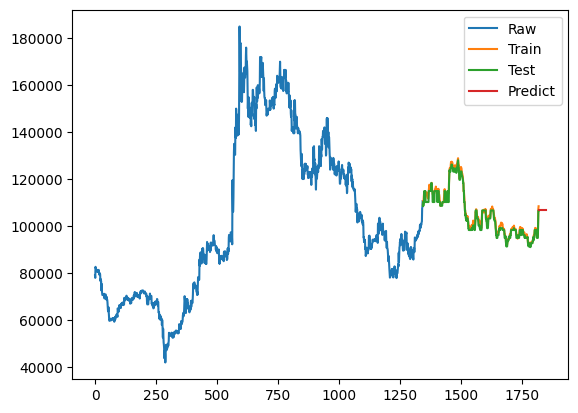

In [19]:
import matplotlib.pyplot as plt

# 14. Vẽ hình

start_idx, stop_idx = 0, len(train_features_rnn) + 100
train_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(train_data_index, scaler.inverse_transform(df1[100: stop_idx + 100]), label='Train')

# # Plotting train data
# start_idx, stop_idx = 0, len(train_features_rnn)
# train_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
# plt.plot(train_data_index, scaler.inverse_transform(train_features_rnn), label='Train')

start_idx, stop_idx = stop_idx, stop_idx + len(test_features_rnn)
# Plotting test data
test_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

start_idx, stop_idx = stop_idx, stop_idx + len(next_30_days_predictions)
# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Raw', 'Train', 'Test', 'Predict', 'Predict30days'])
plt.show()




# Dự báo 60 ngày tiếp theo

In [20]:
def predict_next_days(rnn_model, lgb_model, initial_data, time_step=100, days_to_predict=60):
    predictions = []
    current_sequence = initial_data[:]  # Lấy chuỗi dữ liệu cuối cùng làm dữ liệu khởi đầu

    for _ in range(days_to_predict):
        # Reshape data for prediction
        current_sequence_reshaped = np.expand_dims(current_sequence, axis=0)

        # Predict features using RNN
        rnn_features = rnn_model.predict(current_sequence_reshaped)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the sequence with the new prediction
        next_day = np.array([[next_close[0]]])
        current_sequence = np.vstack((current_sequence[1:], next_day))

    return predictions

# Chuẩn bị dữ liệu ban đầu cho dự đoán 60 ngày tiếp theo
initial_data = df1[:].reshape(-1, 1)

# Dự đoán 60 ngày tiếp theo
days_to_predict = 60
next_60_days_predictions = predict_next_days(rnn_model, lgb_model, initial_data, time_step, days_to_predict)
print("Dự đoán giá đóng cửa cho 60 ngày tiếp theo:", next_60_days_predictions)



1/1 [==============================] - 0s 36ms/step
Dự đoán giá đóng cửa cho 60 ngày tiếp theo: [0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4

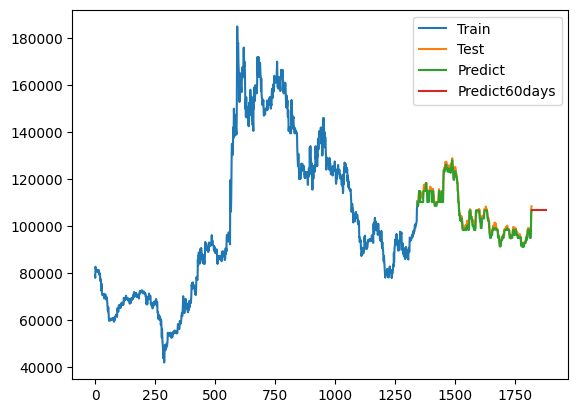

In [21]:

import matplotlib.pyplot as plt

# 14. Vẽ hình

# Plotting train data
start_idx, stop_idx = 0, len(train_features_rnn) + 100
train_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(train_data_index, scaler.inverse_transform(df1[100: stop_idx + 100]), label='Train')

start_idx, stop_idx = stop_idx, stop_idx + len(test_features_rnn)
# Plotting test data
test_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

start_idx, stop_idx = stop_idx, stop_idx + len(next_60_days_predictions)
# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()





In [22]:
def predict_next_days(rnn_model, lgb_model, initial_data, time_step=100, days_to_predict=90):
    predictions = []
    current_sequence = initial_data[:]  # Lấy chuỗi dữ liệu cuối cùng làm dữ liệu khởi đầu

    for _ in range(days_to_predict):
        # Reshape data for prediction
        current_sequence_reshaped = np.expand_dims(current_sequence, axis=0)

        # Predict features using RNN
        rnn_features = rnn_model.predict(current_sequence_reshaped)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the sequence with the new prediction
        next_day = np.array([[next_close[0]]])
        current_sequence = np.vstack((current_sequence[1:], next_day))

    return predictions

# Chuẩn bị dữ liệu ban đầu cho dự đoán 90 ngày tiếp theo
initial_data = df1[:].reshape(-1, 1)

# Dự đoán 90 ngày tiếp theo
days_to_predict = 90
next_90_days_predictions = predict_next_days(rnn_model, lgb_model, initial_data, time_step, days_to_predict)
print("Dự đoán giá đóng cửa cho 90 ngày tiếp theo:", next_90_days_predictions)



1/1 [==============================] - 0s 59ms/step
Dự đoán giá đóng cửa cho 90 ngày tiếp theo: [0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4524158658439045, 0.4

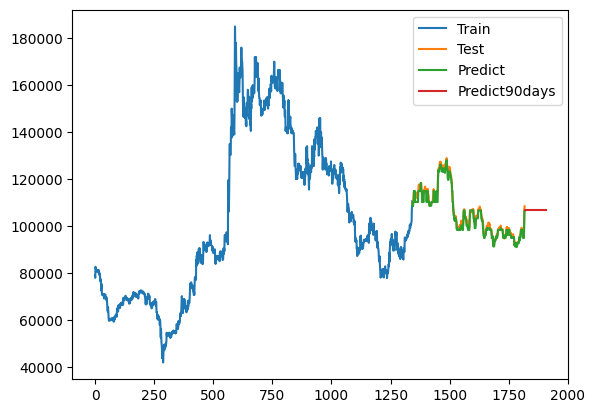

In [23]:

import matplotlib.pyplot as plt

# 14. Vẽ hình

# Plotting train data
start_idx, stop_idx = 0, len(train_features_rnn) + 100
train_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(train_data_index, scaler.inverse_transform(df1[100: stop_idx + 100]), label='Train')

start_idx, stop_idx = stop_idx, stop_idx + len(test_features_rnn)
# Plotting test data
test_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')


start_idx, stop_idx = stop_idx, stop_idx + len(next_90_days_predictions)
# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1)), label='Predict90days')

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()





In [ ]:
len(next_90_days_predictions)


90

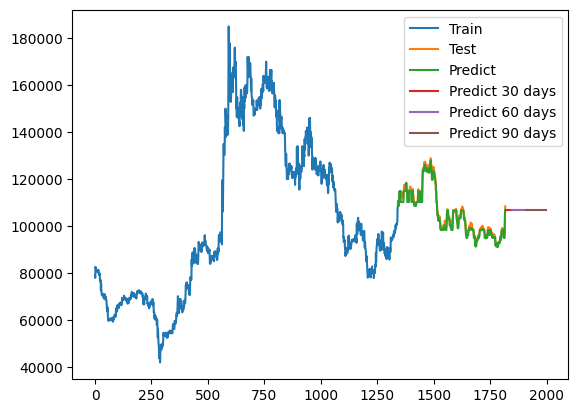

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df1', 'train_features_rnn', 'test_features_rnn', 'y_pred', 'next_30_days_predictions', 'next_60_days_predictions', 'next_90_days_predictions', and 'scaler' are already defined

# Plotting train data
start_idx, stop_idx = 0, len(train_features_rnn) + 100
train_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(train_data_index, scaler.inverse_transform(df1[100: stop_idx + 100]), label='Train')

start_idx, stop_idx = stop_idx, stop_idx + len(test_features_rnn)
# Plotting test data
test_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Plotting next 30 days predictions
start_idx, stop_idx = stop_idx, stop_idx + len(next_30_days_predictions)
predict_30_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(predict_30_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict 30 days')

# Plotting next 60 days predictions
start_idx, stop_idx = stop_idx, stop_idx + len(next_60_days_predictions)
predict_60_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(predict_60_data_index, scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1)), label='Predict 60 days')

# Plotting next 90 days predictions
start_idx, stop_idx = stop_idx, stop_idx + len(next_90_days_predictions)
predict_90_data_index = pd.RangeIndex(start=start_idx, stop=stop_idx, step=1)
plt.plot(predict_90_data_index, scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1)), label='Predict 90 days')

plt.legend(['Train', 'Test', 'Predict', 'Predict 30 days', 'Predict 60 days', 'Predict 90 days'])
plt.show()
